# Pylops - Marchenko imaging with angle gathers

### Authors: M.Ravasi, C. Haindl

In this notebook we show how two of PyLops's applications, namely ``Marchenko`` and ``MDD`` can be used to perform full-wavefield imaging of seismic data.

Let's start from the Marchenko equations:

$$
\mathbf{f^-}  =  \Theta \mathbf{R} \mathbf{f_d^+} + \Theta \mathbf{R} \mathbf{f_m^+} \\
$$
and
$$
\mathbf{f_m^+} = \Theta \mathbf{R^*} \mathbf{f^-}
$$

where $\Theta = \Theta^{-t_d+\epsilon}_{t_d-\epsilon}$.

One way of solving those equations is by rearranging them into a matrix-vector form and apply **direct inversion** (via e.g., LSQR):

$$
        \begin{bmatrix}
           \Theta \mathbf{R} \mathbf{f_d^+}  \\
           \mathbf{0}
        \end{bmatrix} =
        \mathbf{I} -
        \begin{bmatrix}
           \mathbf{0}  &   \Theta \mathbf{R}   \\
           \Theta \mathbf{R^*} & \mathbf{0}
        \end{bmatrix}
        \begin{bmatrix}
           \mathbf{f^-}  \\
           \mathbf{f_m^+}
        \end{bmatrix}
$$

Once the focusing functions are retrieved we can create the up- and down+-going Green's functions by evaluating the following two equation:

$$
\mathbf{g^-}  =  (\mathbf{I} - \Theta) \mathbf{R} \mathbf{f^+} \\
\mathbf{g^{+*}}  =  -(\mathbf{I} - \Theta) \mathbf{R^*} \mathbf{f^-}
$$

This can be achieved by using the ``Marchenko`` routine.

After that, we can find the local reflectivity in the subsurface by feeding the estimated Green's functions to the 
 ``MDD`` routine, which solves the following problem:
 
$$
\mathbf{g^-}  =  \mathbf{G^+} \mathbf{r}
$$

By repeating the same operation for multiple depth levels we can create an image of the uderlying subsurface. Here we also use the ``AngleGather`` routine to compute angle gathers alongside with depth images.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import directwave, Marchenko
from pylops.optimization.leastsquares  import *

from AngleGather import AngleGather

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s
jt = 1              # subsampling for MDD

igaths = [21, 31, 
          41, 51, 
          61]       # indeces of Angle gathers
nalpha = 41         # number of angles in Angle gathers
plotflag = False

ngath = len(igaths)

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)
t2 = np.hstack((-t[::-1], t[1:]))

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

In [6]:
wav = inputdata['wav']
wav_c = np.argmax(wav)

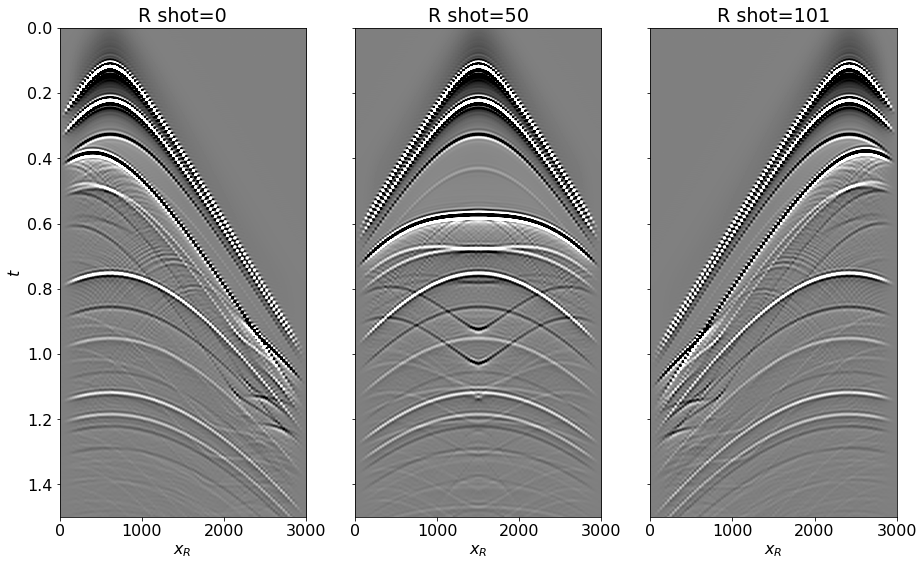

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0);

Define imaging domain

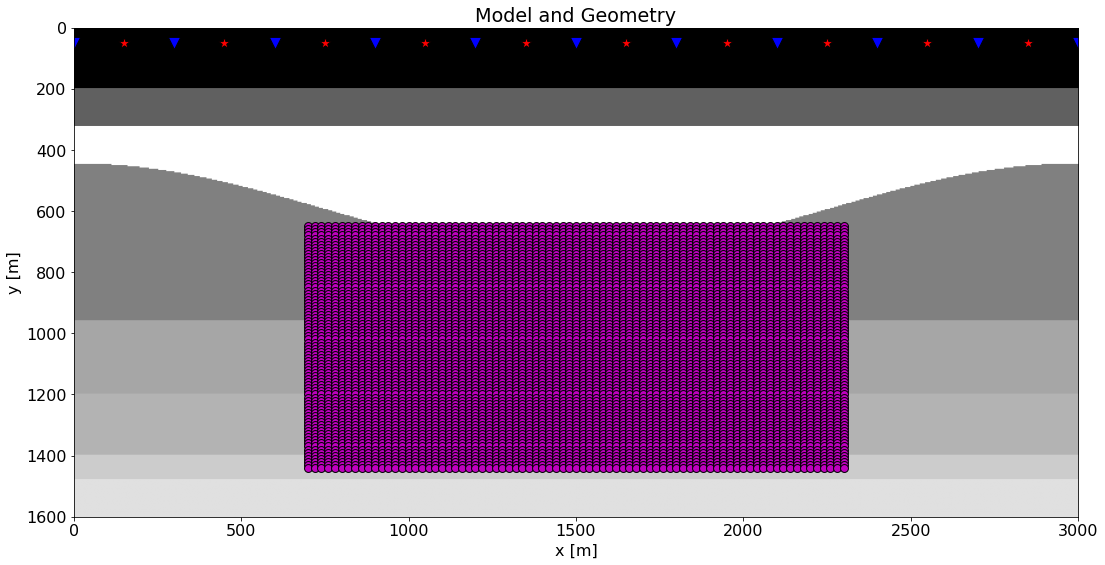

In [8]:
#nvsx, nvsz = 81, 1
#dvsx, dvsz = 20, 10
#vsx = np.arange(nvsx)*dvsx + 700
#vsz = np.arange(nvsz)*dvsz + 850

nvsx, nvsz = 81, 80
dvsx, dvsz = 20, 10
vsx = np.arange(nvsx)*dvsx + 700
vsz = np.arange(nvsz)*dvsz + 650

VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Perform imaging for the different depth levels

In [9]:
irtm = np.zeros((nvsz, nvsx))
imck = np.zeros((nvsz, nvsx))
artm = np.zeros((ngath, nvsz, nalpha))
amck = np.zeros((ngath, nvsz, nalpha))

for ivsz in range(nvsz):
    print('Working on %d/%d' % (ivsz, nvsz))
    # Marchenko redatuming
    directVS = np.sqrt((vsx-r[0][:, np.newaxis])**2+(vsz[ivsz]-r[1][:, np.newaxis])**2)/vel
    directVS_off = directVS - toff

    if plotflag:
        plt.figure()
        im = plt.imshow(directVS, cmap='gist_rainbow')
        plt.axis('tight')
        plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
        plt.colorbar(im);
    
    idirectVS_off = np.round(directVS_off/dt).astype(np.int)
    w = np.zeros((nr, nvsx, nt))
    for ir in range(nr):
        for ivs in range(nvsx):
            w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
    w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)

    if nsmooth>0:
        smooth=np.ones(nsmooth)/nsmooth
        w  = filtfilt(smooth, 1, w)    
    
    if plotflag:
        fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
        im = axs[0].imshow(w[nr//2].T, cmap='gray', extent=(vsx[0], vsx[-1], t[-1], -t[-1]))
        axs[0].plot(vsx, directVS[nr//2],'b'),axs[0].plot(vsx, -directVS[nr//2],'b')
        axs[0].set_title('Window (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
        axs[0].axis('tight')
        fig.colorbar(im, ax=axs[0])
        im = axs[1].imshow(w[:, nvsx//2].T, cmap='gray', 
                           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
        axs[1].plot(r[0], directVS[:, nvsx//2],'b'),axs[1].plot(r[0], -directVS[:, nvsx//2],'b')
        axs[1].set_title('Window (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
        axs[1].axis('tight')
        fig.colorbar(im, ax=axs[1])
    
    G0sub_ana = np.zeros((nr, nvsx, nt))
    for ivs in range(nvsx):
        G0sub_ana[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

    if plotflag:
        fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
        im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vsx[0], vsx[-1], t[-1], t[0]))
        axs[0].plot(vsx, directVS[nr//2],'b')
        axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
        axs[0].axis('tight')
        fig.colorbar(im, ax=axs[0])
        im = axs[1].imshow(G0sub_ana[:,nvsx//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
        axs[1].plot(r[0], directVS[:, nvsx//2],'b')
        axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
        axs[1].axis('tight')
        fig.colorbar(im, ax=axs[1])

    MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                            toff=toff, nsmooth=nsmooth)
    f1_inv_minus, f1_inv_plus, p0_minus, g_inv_minus, g_inv_plus = \
        MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True, 
                                         dottest=False, **dict(iter_lim=n_iter, show=False))
    
    if plotflag:
        fig, axs = plt.subplots(5, 1, sharex=True, figsize=(16, 22))
        axs[0].imshow(np.swapaxes(p0_minus, 0, 1).reshape(nr*nvsx, 2*nt-1).T, cmap='gray', 
                      vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvsx, t[-1], -t[-1]))
        axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
        axs[0].axis('tight')
        axs[0].set_ylim(1, -1);
        axs[1].imshow(np.swapaxes(f1_inv_minus, 0, 1).reshape(nr*nvsx,2*nt-1).T, cmap='gray', 
                      vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvsx, t[-1], -t[-1]))
        axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
        axs[1].axis('tight')
        axs[1].set_ylim(1, -1);
        axs[2].imshow(np.swapaxes(f1_inv_plus, 0, 1).reshape(nr*nvsx,2*nt-1).T, cmap='gray', 
                      vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvsx, t[-1], -t[-1]))
        axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
        axs[2].axis('tight')
        axs[2].set_ylim(1, -1);
        axs[3].imshow(np.swapaxes(g_inv_minus, 0, 1).reshape(nr*nvsx,2*nt-1).T, cmap='gray', 
                      vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvsx, t[-1], -t[-1]))
        axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
        axs[3].axis('tight')
        axs[3].set_ylim(2, 0);
        axs[4].imshow(np.swapaxes(g_inv_plus, 0, 1).reshape(nr*nvsx,2*nt-1).T, cmap='gray', 
                      vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvsx, t[-1], -t[-1]))
        axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
        axs[4].axis('tight')
        axs[4].set_ylim(2, 0)
        axs[4].set_xlim(4000, 6000);
        
    # MDD
    _, Rrtm = MDD(G0sub_ana[:, :, ::jt], p0_minus[:, :, nt-1:][:, :, ::jt], 
                  dt=jt*dt, dr=dvsx, twosided=True, adjoint=True, psf=False, wav=wav[wav_c-60:wav_c+60],
                  nfmax=nfmax, dottest=False, **dict(iter_lim=0, show=0))
 
    Rmck = MDD(g_inv_plus[:, :, nt-1:][:, :, ::jt], g_inv_minus[:, :, nt-1:][:, :, ::jt], 
               dt=jt*dt, dr=dvsx, twosided=True, adjoint=False, psf=False, wav=wav[wav_c-60:wav_c+60],
               nfmax=nfmax, dottest=False, **dict(iter_lim=10, show=0))
    if plotflag:
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
    axs[0].imshow(Rrtm.reshape(nvsx**2, 2*nt-1).T, cmap='gray', 
               vmin=-5e1, vmax=5e1, extent=(0, nr*nvsx, t[-1], -t[-1]))
    axs[0].axis('tight')
    axs[0].set_ylim(1, -1);
    axs[1].imshow(Rmck.reshape(nvsx**2, 2*nt-1).T, cmap='gray', 
               vmin=-5e-4, vmax=5e-4, extent=(0, nr*nvsx, t[-1], -t[-1]))
    axs[1].axis('tight')
    axs[1].set_ylim(1, -1);
    axs[1].set_xlim(4000, 6000);
    
    # Images
    irtm[ivsz] = np.diag(Rrtm[:, :, nt-1])
    imck[ivsz] = np.diag(Rmck[:, :, nt-1])
    
    # Angle gathers
    for i, igath in enumerate(igaths):
        artm[i, ivsz], angle, Ra = AngleGather(Rrtm.transpose(2, 0, 1), nvsx, nalpha, 
                                               dt*jt, dvsx, igath, vel, plotflag=plotflag)
        amck[i, ivsz], angle, Ra = AngleGather(Rmck.transpose(2, 0, 1), nvsx, nalpha, 
                                               dt*jt, dvsx, igath, vel, plotflag=plotflag)

Working on 0/80
Working on 1/80
Working on 2/80
Working on 3/80
Working on 4/80
Working on 5/80
Working on 6/80
Working on 7/80
Working on 8/80
Working on 9/80
Working on 10/80
Working on 11/80
Working on 12/80
Working on 13/80
Working on 14/80
Working on 15/80
Working on 16/80
Working on 17/80
Working on 18/80
Working on 19/80
Working on 20/80
Working on 21/80
Working on 22/80
Working on 23/80
Working on 24/80
Working on 25/80
Working on 26/80
Working on 27/80
Working on 28/80
Working on 29/80
Working on 30/80
Working on 31/80
Working on 32/80
Working on 33/80
Working on 34/80
Working on 35/80
Working on 36/80
Working on 37/80
Working on 38/80
Working on 39/80
Working on 40/80
Working on 41/80
Working on 42/80
Working on 43/80
Working on 44/80
Working on 45/80
Working on 46/80
Working on 47/80
Working on 48/80
Working on 49/80
Working on 50/80
Working on 51/80
Working on 52/80
Working on 53/80
Working on 54/80
Working on 55/80
Working on 56/80
Working on 57/80
Working on 58/80
Working

Visualize the stardard single-scattering (eg RTM) image and the Marchenko image

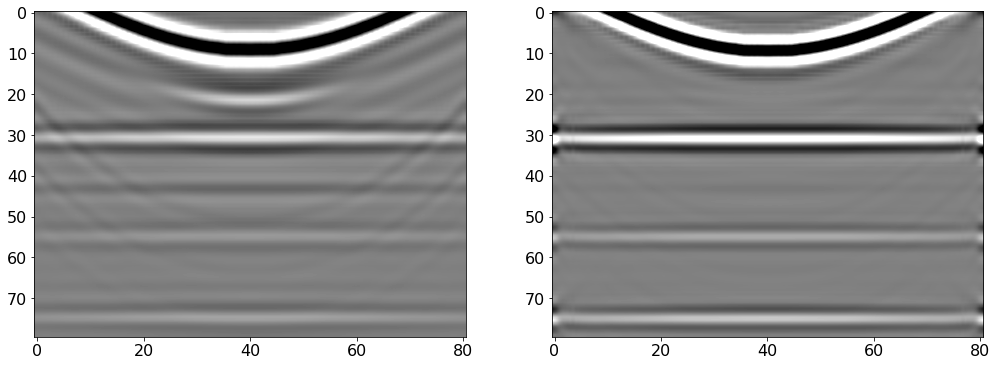

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(irtm, cmap='gray', vmin=-1e3, vmax=1e3, interpolation='sinc')
axs[0].axis('tight')
axs[1].imshow(imck, cmap='gray', vmin=-1e-2, vmax=1e-2, interpolation='sinc')
axs[1].axis('tight');

And the same for angle gathers

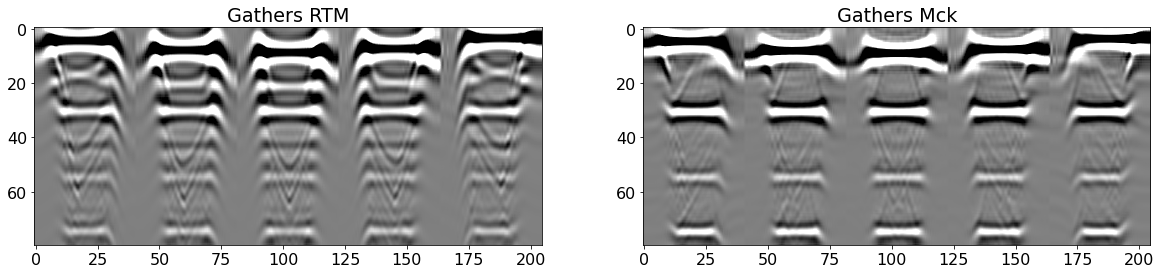

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs[0].imshow(artm.transpose(0, 2, 1).reshape(ngath*nalpha, nvsz).T, cmap='gray', vmin=-1e6, vmax=1e6,
              interpolation='sinc')
axs[0].axis('tight')
axs[0].set_title('Gathers RTM')
axs[1].imshow(amck.transpose(0, 2, 1).reshape(ngath*nalpha, nvsz).T, cmap='gray', vmin=-1e1, vmax=1e1,
              interpolation='sinc')
axs[1].set_title('Gathers Mck')
axs[1].axis('tight');

That's it! You have learned how to perform full-wavefield seismic imaging using one of the newest and most advanced imaging algorithms outthere.

You can now apply it to your data or dig deeper into the source code to adapt it to your own problems in geophysics and perhaps other fields.

Some example of variations of this method can be found at:

- Iterative method for redatuming and data demultiple: 
https://github.com/mrava87/pylops_notebooks/blob/master/developement/Marchenko_iterative.ipynb

- Redatuming with missing sources: 
https://github.com/mrava87/pylops_notebooks/blob/master/developement/Marchenko_missing.ipynb